In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
import nltk
import re
import os
import codecs

import mpld3
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

from sklearn.manifold import MDS
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import joblib



In [2]:
aita = pd.read_pickle('processed_aita.pickle')
aita = aita.sample(frac=1).reset_index(drop=True)
aita.shape

(18554, 38)

In [3]:
# need to remove reddit post common words.. these are not part of the story but a function of posting on reddit
aita['proc_text'] = [x.replace('x200b', '') for x in aita['proc_text']]
aita['proc_text'] = [x.replace('edit', '') for x in aita['proc_text']]
aita['proc_text'] = [x.replace('removed', '') for x in aita['proc_text']]
aita['proc_text'] = [x.replace('deleted', '') for x in aita['proc_text']]
#aita['proc_title'] = [x.replace('x200b', '') for x in aita['proc_title']]

In [4]:
aita.head()

,created_utc,subreddit,author,domain,url,num_comments,score,ups,downs,title,selftext,saved,id,from_kind,gilded,from,stickied,retrieved_on,over_18,thumbnail,subreddit_id,hide_score,link_flair_css_class,author_flair_css_class,archived,is_self,from_id,permalink,name,author_flair_text,quarantine,link_flair_text,distinguished,title_length,post_length,label_id,proc_title,proc_text
0,1564705182,AmItheAsshole,MajesticGuide,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,78,247,None,None,AITA for asking my girlfriend to stop using su...,My girlfriend has naturally dry skin. She has ...,None,ckwolt,None,0,None,False,1567081523,False,self,t5_2xhvq,None,ass,None,False,True,None,/r/AmItheAsshole/comments/ckwolt/aita_for_aski...,None,None,False,Asshole,None,11,177,1,asking girlfriend stop using thick lotion,girlfriend naturally dry skin thyroid disorder...
1,1560611932,AmItheAsshole,throwasyandis,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,452,664,None,None,AITA for not wanting to have sex with my girlf...,"I always wear a condom, but condoms have broke...",None,c0ydru,None,0,None,False,1566315849,False,self,t5_2xhvq,None,not,None,False,True,None,/r/AmItheAsshole/comments/c0ydru/aita_for_not_...,None,None,False,No A-holes here,None,19,100,3,wanting sex girlfriend unless get form birth ...,always wear condom condom broken several time ...
2,1565191226,AmItheAsshole,slightlyaveragehuman,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,151,99,None,None,AITA for blocking a child from fully reclining...,Some context. \n\nThis was a short haul flight...,None,cn74ru,None,0,None,False,1566431511,False,self,t5_2xhvq,None,not,None,False,True,None,/r/AmItheAsshole/comments/cn74ru/aita_for_bloc...,None,None,False,No A-holes here,None,13,229,3,blocking child fully reclining seat plane,context short haul flight 2 hour middle aftern...
3,1562217865,AmItheAsshole,[deleted],self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,52,102,None,None,AITA for refusing to go on a family vacation w...,[deleted],None,c8ynb0,None,0,None,False,1566820039,False,default,t5_2xhvq,None,not,None,False,True,None,/r/AmItheAsshole/comments/c8ynb0/aita_for_refu...,None,None,False,Not the A-hole,None,13,1,0,refusing go family vacation boyfriend family,
4,1561303912,AmItheAsshole,throwawayyyy32123,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,20,47,None,None,AITA for telling my mom that I don't want to l...,Throwaway just in case.\n\nSome backstory: A l...,None,c46ekr,None,0,None,False,1566728470,False,self,t5_2xhvq,None,not,None,False,True,None,/r/AmItheAsshole/comments/c46ekr/aita_for_tell...,None,None,False,No A-holes here,None,14,564,3,telling mom want live house,throwaway case backstory little 5 year ago mom...


In [5]:
tfidf = TfidfVectorizer(max_df=0.8
                        , max_features=200000
                        , min_df=0.2
                        ,sublinear_tf=True
                        , ngram_range=(1, 3)
                        , stop_words='english')

%time tfidf_matrix = tfidf.fit_transform(aita['proc_text']) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

CPU times: user 14.5 s, sys: 491 ms, total: 15 s
Wall time: 15 s
(18554, 40)


In [6]:
MACHINE_EPSILON = np.finfo(np.double).eps
n_components = 2
perplexity = 30

In [12]:
tsne = TSNE(n_components = 2 # 2d graph output
           , perplexity = 2
           , n_iter = 5000 # 5000 iterations
            , n_iter_without_progress = 300 
            , n_jobs = -1 #use all processors 
           , random_state = 420)
X_embedded = tsne.fit_transform(tfidf_matrix.toarray())

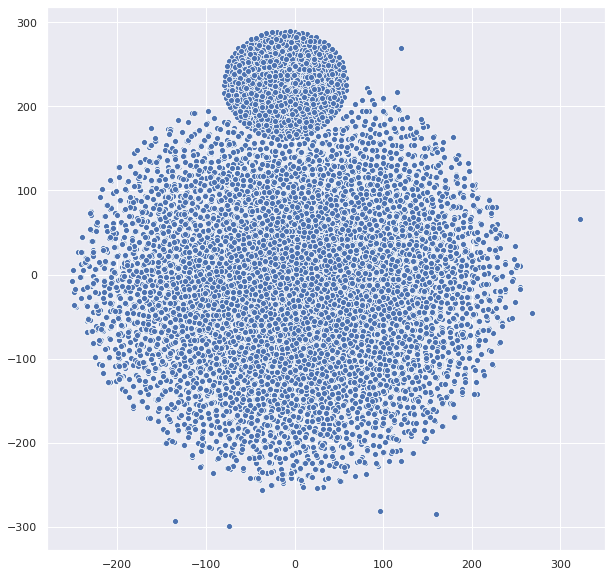

In [13]:

fig_dims = (10, 10)

fig, ax = plt.subplots(figsize=fig_dims)

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette);#, hue=y, legend='full'

In [9]:


terms = tfidf.get_feature_names()
dist = 1 - cosine_similarity(tfidf_matrix)



In [10]:
num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 52.7 s, sys: 4.15 ms, total: 52.7 s
Wall time: 52.7 s


In [11]:
#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()